## Time-Series Forecasting: Predicting Stock Prices Using Deeping Learning Models

### The Objective of the Time-Series Forecasting Project:

Forecasting stock market is the act of trying to predict the future value of a company stock or other financial instrument traded on an exchange. The successful forecasting of a stock's future price could yield significant financial profit. The objective of this project is to build time-series models using deep learning modeling (e.g., RNN and LSTM) and to evaluate which DL model is the best in forecasting stock prices. In this project, Google's stock prices were used as the time series dataset for training forecasting models. The time series dataset of Google's stock prices was downloaded from Yahoo finance at the website address: https://finance.yahoo.com/quote/GOOG/history?period1=1262390400&period2=1619827200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true.

The downloaded time series dataset covers the historic stock prices of Google between 1/4/2010 and 4/30/2021.


### An outline of the time-series forecasting project plan:

1. The dataset was first examined to check whether there are any missing values in attributes. Missing values will be replaced by the interpolation method.
2. Engineering the dataset was performed to create time series datasets for training time-series models and the forecasting purpose.
3. Exploratory data analysis of the time-series dataset.
4. Forecasting of Google's stock prices using deep learning algorithms (RNN and LSTM) built by Tensorflow.Keras.
5. These time-series prediction models were evaluated to identify the best model for forecasting Google's stock prices.

### The description of the dataset:

The downloaded dataset from Yahoo finance includes the following 7 variables:
1. Date: stock market date
2. Open: the beginning stock price when the stock market opened
3. High: the highest stock price during stock market transactions
4. Low: the lowest stock price during stock market transactions
5. Close: the final stock price when the stock market closed
6. Adj Close: the adjusted stock price according to the close price
7. Volume: the volume of stock transactions

"Date" was used as a time variable and "Close" was used as a target variable for forecasting. The dataset contains 2851 observations.


In [1]:
# Import libraries
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
import sys, os
os.chdir('data')
import warnings
warnings.simplefilter(action='ignore')

Using TensorFlow backend.


### Data Cleaning and Feature Engineering:

In [2]:
# Read Google's stock price dataset
df = pd.read_csv("GOOG.csv")
print(df.shape)
df.head(5)

(2851, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927065
1,2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031925
2,2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987226
3,2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876685
4,2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9484016


In [3]:
# Check data types
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
# Check missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Create a new stock price dataset covering from 2016-01-04 to 2021-03-02
df2 = df[1510:2809]
df2 = df2[['Date', 'Close']]
print(df2.Date.head())
print(df2.Date.tail())

1510    2016-01-04
1511    2016-01-05
1512    2016-01-06
1513    2016-01-07
1514    2016-01-08
Name: Date, dtype: object
2804    2021-02-24
2805    2021-02-25
2806    2021-02-26
2807    2021-03-01
2808    2021-03-02
Name: Date, dtype: object


In [6]:
# Engineer the dataset
df2.index = pd.to_datetime(df2.Date)
df2.drop('Date', axis=1, inplace=True)
df2.rename(columns={'Close':'price'}, inplace=True)
print(len(df2))
print(df2.index)
df2.head()

1299
DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22',
               '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26',
               '2021-03-01', '2021-03-02'],
              dtype='datetime64[ns]', name='Date', length=1299, freq=None)


,price
Date,
2016-01-04,741.840027
2016-01-05,742.580017
2016-01-06,743.619995
2016-01-07,726.390015
2016-01-08,714.469971


For training RNN and LSTM models, the time series data were engineered to create train and test datasets, which were further scaled by MinMaxScaler().

In [7]:
# Create training and test datasets. The test dataset contains stock prices for last 200 days
training_set = df2.iloc[:-200, 0].values
test_set = df2.iloc[-200:, 0].values

In [8]:
# Examine the length of the taining dataset
print(len(training_set))
print(training_set.shape)
training_set

1099
(1099,)


array([ 741.840027,  742.580017,  743.619995, ..., 1375.73999 ,
       1349.329956, 1356.130005])

In [9]:
# Examine the length of the test dataset
print(len(test_set))
print(test_set.shape)

200
(200,)


In [10]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1099):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
# Examine X_train
print(X_train.shape)
X_train

(1039, 60, 1)


array([[[0.08571465],
        [0.08657667],
        [0.08778816],
        ...,
        [0.07603418],
        [0.08912785],
        [0.09583778]],

       [[0.08657667],
        [0.08778816],
        [0.06771666],
        ...,
        [0.08912785],
        [0.09583778],
        [0.08933752]],

       [[0.08778816],
        [0.06771666],
        [0.05383079],
        ...,
        [0.09583778],
        [0.08933752],
        [0.09511547]],

       ...,

       [[0.9930688 ],
        [0.9918224 ],
        [1.        ],
        ...,
        [0.82045141],
        [0.83886868],
        [0.85621432]],

       [[0.9918224 ],
        [1.        ],
        [0.9900517 ],
        ...,
        [0.83886868],
        [0.85621432],
        [0.82415577]],

       [[1.        ],
        [0.9900517 ],
        [0.95156278],
        ...,
        [0.85621432],
        [0.82415577],
        [0.79339026]]])

In [12]:
# Examine y_train
print(y_train.shape)
y_train

(1039,)


array([0.08933752, 0.09511547, 0.08973355, ..., 0.82415577, 0.79339026,
       0.80131176])

### Forecasting by RNN modeling:

#### Build a RNN model

In [13]:
# Build the RNN with 50 neurons and 4 hidden layers. 
# Assign 1 neuron in the output layer for predicting the normalized stock price.

RNN_model = Sequential()

#Adding the first RNN layer and some Dropout regularisation
RNN_model.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
RNN_model.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularisation
RNN_model.add(SimpleRNN(units = 50, return_sequences = True))
RNN_model.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation
RNN_model.add(SimpleRNN(units = 50, return_sequences = True))
RNN_model.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation
RNN_model.add(SimpleRNN(units = 50))
RNN_model.add(Dropout(0.2))

# Adding the output layer
RNN_model.add(Dense(units = 1))

# Compiling the RNN
RNN_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 60, 50)            2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 50)            5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 60, 50)            5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 50)               

In [15]:
# Fitting the RNN to the Training set using the MSE loss function and the Adam stochastic gradient descent optimizer.
# Fit the RNN model for 100 epochs.
RNN_model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1039/1039 [==============================] - 4s 4ms/step - loss: 0.4064
Epoch 2/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.2524
Epoch 3/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.1835
Epoch 4/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.1400
Epoch 5/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.1083
Epoch 6/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0879
Epoch 7/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0823
Epoch 8/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0676
Epoch 9/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0633
Epoch 10/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0493
Epoch 11/100
1039/1039 [==============================] - 2s 2ms/step - loss: 0.0428
Epoch 12/100
1039/1039 [==============================] - 2s 2ms/step - lo

In [16]:
# Forecast the stock price for one future day using the RNN model
inputs = df2.price[1039:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 260):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(200, 60, 1)


In [17]:
# Use the trained RNN model to predict the stock price of each day according to prior 60-day stock prices
predicted_stock_price = RNN_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [18]:
# Define a function to calculate mean absolute percentage error
def mape(df):
    y_true, y_pred = np.array(df.actual), np.array(df.fcst)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
# Define a function to calculate mean squared error
def mse(df):
    return mean_squared_error(df.actual, df.fcst)

In [20]:
# Define a function to calculate mean absolute error
def mae(df):
    return mean_absolute_error(df.actual, df.fcst)

In [21]:
# Analysis of errors of predicted prices for 200 days (prediction for one future day each time) from the RNN model
df = pd.DataFrame({'actual':df2[-200:].values.reshape(-1,), 'fcst':predicted_stock_price.reshape(-1,)})

Mse = mse(df)
Mape = mape(df)
Mae = mae(df)
print('Testing Mean Squared Error for the RNN model is {}'.format(Mse))
print('Testing mape for the RNN model is {}'.format(Mape))
print('Testing mae for the RNN model is {}'.format(Mae))

Testing Mean Squared Error for the RNN model is 17787.724126169647
Testing mape for the RNN model is 5.064125810049786
Testing mae for the RNN model is 92.28265504597657


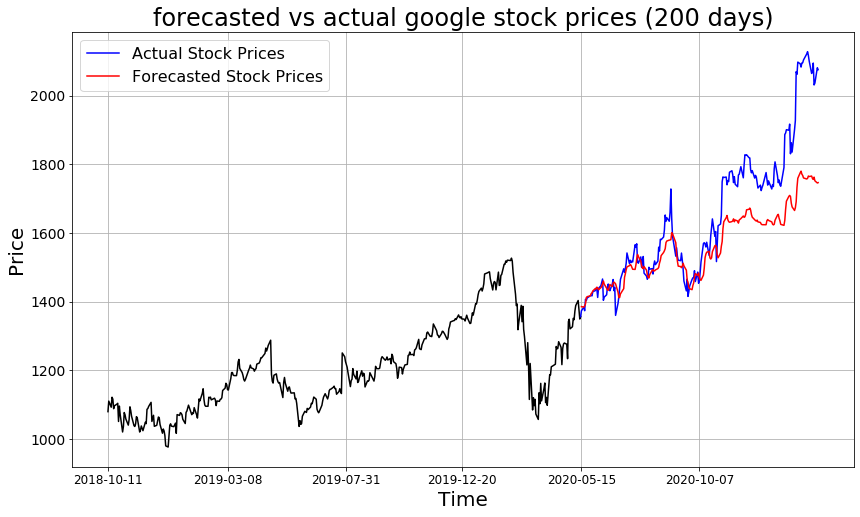

In [22]:
# Plot predictions from the RNN model (prediction of one future day each time)
plt.figure(figsize=(14, 8))
plt.plot(df2[-600:-200], 'k-')
plt.plot(df2[-201:], 'b-', label='Actual Stock Prices')
plt.plot(df2[-200:].index, predicted_stock_price, 'r-', label='Forecasted Stock Prices')
plt.xticks(df2[-600:-1:100].index, fontsize=12)
plt.yticks(fontsize=14)
plt.title('forecasted vs actual google stock prices (200 days)', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(fontsize=16)
plt.grid();

In [23]:
# Forecast the stock prices for five future days using the RNN model
inputs = df2.price[1039:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
preds = []

for i in range(0,200,5):
    X_init = inputs[i:60+i,0].copy().reshape(1,-1,1)
    for _ in range(5):
        pred = RNN_model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 59 values with 2nd through 60th
        X_init[:,-1,:] = pred # replace the last value with prediction

preds = np.array(preds).reshape(-1,1)
print(preds.shape)
preds    

(200, 1)


array([[0.8355034 ],
       [0.8378139 ],
       [0.84325844],
       [0.85539776],
       [0.87298673],
       [0.8691083 ],
       [0.87351125],
       [0.88119715],
       [0.8859244 ],
       [0.89552826],
       [0.8965096 ],
       [0.8973063 ],
       [0.90317696],
       [0.90230805],
       [0.905464  ],
       [0.90004426],
       [0.90199524],
       [0.9075604 ],
       [0.910868  ],
       [0.91797894],
       [0.89780194],
       [0.897939  ],
       [0.8959927 ],
       [0.89822835],
       [0.9087771 ],
       [0.9033354 ],
       [0.91308933],
       [0.9119345 ],
       [0.91676146],
       [0.91961676],
       [0.88469857],
       [0.8772914 ],
       [0.8796832 ],
       [0.8836203 ],
       [0.884873  ],
       [0.93485886],
       [0.9421542 ],
       [0.9500707 ],
       [0.95304304],
       [0.94352937],
       [0.9784371 ],
       [0.9719116 ],
       [0.9618382 ],
       [0.9488207 ],
       [0.9404902 ],
       [0.9770829 ],
       [0.98188907],
       [0.979

In [24]:
# Use the trained RNN model to predict stock prices of five future days according to prior 60-day stock prices
predicted_stock_price = sc.inverse_transform(preds)
predicted_stock_price

array([[1385.4811],
       [1387.4645],
       [1392.1383],
       [1402.5591],
       [1417.658 ],
       [1414.3286],
       [1418.1082],
       [1424.706 ],
       [1428.764 ],
       [1437.0083],
       [1437.8507],
       [1438.5347],
       [1443.5741],
       [1442.8282],
       [1445.5374],
       [1440.8849],
       [1442.5597],
       [1447.337 ],
       [1450.1764],
       [1456.2806],
       [1438.9601],
       [1439.0778],
       [1437.407 ],
       [1439.326 ],
       [1448.3815],
       [1443.7101],
       [1452.0833],
       [1451.0919],
       [1455.2355],
       [1457.6865],
       [1427.7117],
       [1421.3531],
       [1423.4064],
       [1426.7861],
       [1427.8615],
       [1470.7708],
       [1477.0333],
       [1483.8291],
       [1486.3806],
       [1478.2139],
       [1508.1797],
       [1502.578 ],
       [1493.9307],
       [1482.7561],
       [1475.6049],
       [1507.0172],
       [1511.143 ],
       [1509.4246],
       [1507.497 ],
       [1502.8624],


In [25]:
# Analysis of errors of predicted prices for 200 days (prediction for five future days each time) from the RNN model
df = pd.DataFrame({'actual':df2[-200:].values.reshape(-1,), 'fcst':predicted_stock_price.reshape(-1,)})

Mse = mse(df)
Mape = mape(df)
Mae = mae(df)
print('Testing Mean Squared Error for the RNN model is {}'.format(Mse))
print('Testing mape for the RNN model is {}'.format(Mape))
print('Testing mae for the RNN model is {}'.format(Mae))

Testing Mean Squared Error for the RNN model is 39190.22347422135
Testing mape for the RNN model is 7.248885901626406
Testing mae for the RNN model is 132.76016603503905


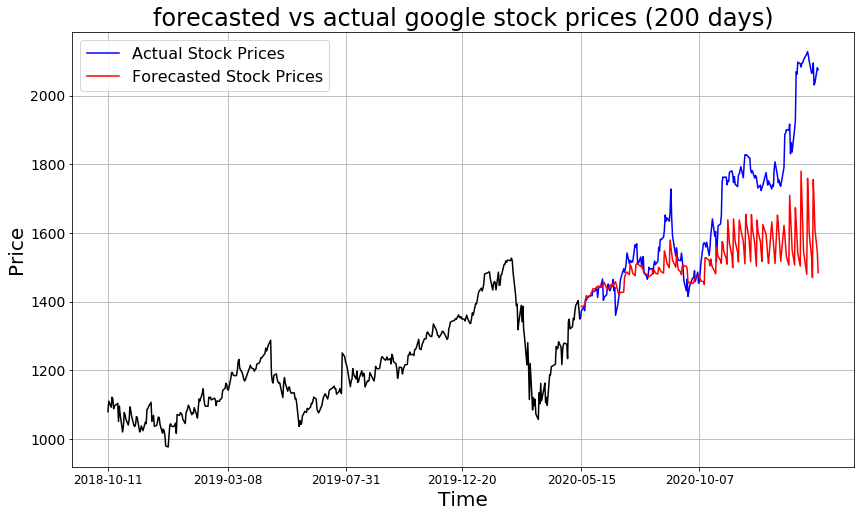

In [26]:
# Plot predictions from the RNN model (prediction of five future days each time)
plt.figure(figsize=(14, 8))
plt.plot(df2[-600:-200], 'k-')
plt.plot(df2[-201:], 'b-', label='Actual Stock Prices')
plt.plot(df2[-200:].index, predicted_stock_price, 'r-', label='Forecasted Stock Prices')
plt.xticks(df2[-600:-1:100].index, fontsize=12)
plt.yticks(fontsize=14)
plt.title('forecasted vs actual google stock prices (200 days)', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(fontsize=16)
plt.grid();

### Forecasting by LSTM modeling:

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) with the improved neural network architecture used in the field of deep learning. LSTM possesses feedback connections, which is unlike standard feedforward neural networks. In other words, LSTM has a memory capacity. LSTM models are able to memorize information over a period of time. This feature is extremely powerful for dealing with Time-Series or Sequential Data.

For forecasting Google's stock prices, the LSTM model was built as follows by Tensorflow.Keras. The built LSTM model significantly used more parameters for model fitting when compared to the standard RNN model.


#### Build a LSTM model

In [27]:
# Build the LSTM with 50 neurons and 4 hidden layers. 
# Assign 1 neuron in the output layer for predicting the normalized stock price.

LSTM_model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50))
LSTM_model.add(Dropout(0.2))

# Adding the output layer
LSTM_model.add(Dense(units = 1))

# Compiling the LSTM
LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [28]:
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [29]:
# Fitting the LSTM to the Training set using the MSE loss function and the Adam stochastic gradient descent optimizer.
# Fitting the LSTM model for 100 epochs
LSTM_model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1039/1039 [==============================] - 10s 10ms/step - loss: 0.0358
Epoch 2/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0074
Epoch 3/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0069
Epoch 4/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0067
Epoch 5/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0057
Epoch 6/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0060
Epoch 7/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0059
Epoch 8/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0048
Epoch 9/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0045
Epoch 10/100
1039/1039 [==============================] - 7s 6ms/step - loss: 0.0045
Epoch 11/100
1039/1039 [==============================] - 7s 7ms/step - loss: 0.0042
Epoch 12/100
1039/1039 [==============================] - 7s 6ms/step - 

In [30]:
# Forecast the stock price for one future day using the LSTM model
inputs = df2.price[1039:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 260):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(200, 60, 1)


In [31]:
# Use the trained LSTM model to predict the stock price of each day according to prior 60-day stock prices
predicted_stock_price = LSTM_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [32]:
# Analysis of errors of predicted prices for 200 days (prediction for one future day each time) from the LSTM model
df = pd.DataFrame({'actual':df2[-200:].values.reshape(-1,), 'fcst':predicted_stock_price.reshape(-1,)})

Mse = mse(df)
Mape = mape(df)
Mae = mae(df)
print('Testing Mean Squared Error for the RNN model is {}'.format(Mse))
print('Testing mape for the RNN model is {}'.format(Mape))
print('Testing mae for the RNN model is {}'.format(Mae))

Testing Mean Squared Error for the RNN model is 2593.8180739356144
Testing mape for the RNN model is 2.415802545051476
Testing mae for the RNN model is 39.74003421035156


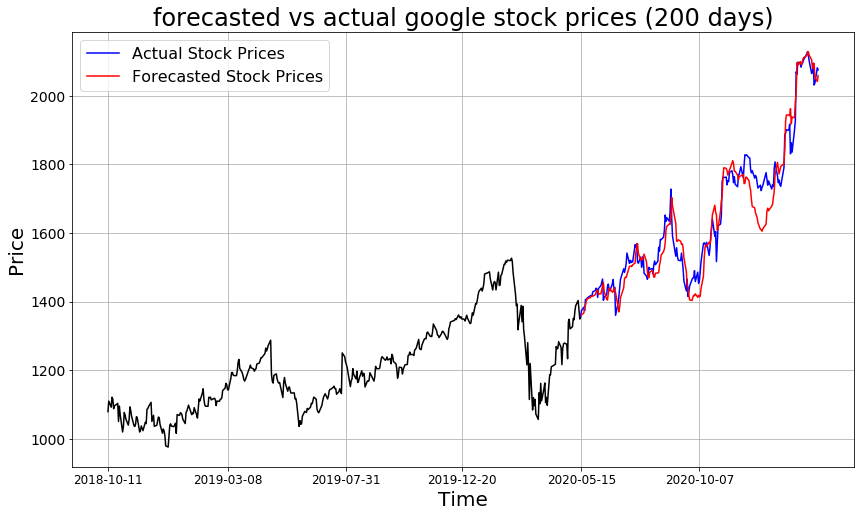

In [33]:
# Plot predictions from the LSTM model (prediction of one future day each time)
plt.figure(figsize=(14, 8))
plt.plot(df2[-600:-200], 'k-')
plt.plot(df2[-201:], 'b-', label='Actual Stock Prices')
plt.plot(df2[-200:].index, predicted_stock_price, 'r-', label='Forecasted Stock Prices')
plt.xticks(df2[-600:-1:100].index, fontsize=12)
plt.yticks(fontsize=14)
plt.title('forecasted vs actual google stock prices (200 days)', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(fontsize=16)
plt.grid();

In [34]:
# Forecast the stock prices for five future days using the LSTM model
inputs = df2.price[1039:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
preds = []

for i in range(0,200,5):
    X_init = inputs[i:60+i,0].copy().reshape(1,-1,1)
    for _ in range(5):
        pred = LSTM_model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 59 values with 2nd through 60th
        X_init[:,-1,:] = pred # replace the last value with prediction

preds = np.array(preds).reshape(-1,1)
print(preds.shape)
preds

(200, 1)


array([[0.8067561 ],
       [0.8079582 ],
       [0.8158431 ],
       [0.8248006 ],
       [0.83254886],
       [0.8621994 ],
       [0.86505413],
       [0.86541927],
       [0.8646618 ],
       [0.8634553 ],
       [0.87630415],
       [0.876704  ],
       [0.87483627],
       [0.872434  ],
       [0.87005293],
       [0.8792518 ],
       [0.8787921 ],
       [0.8765997 ],
       [0.87358785],
       [0.87004393],
       [0.8613991 ],
       [0.8513286 ],
       [0.8474474 ],
       [0.84487844],
       [0.84154606],
       [0.8844279 ],
       [0.87248147],
       [0.8616268 ],
       [0.85163605],
       [0.84225297],
       [0.83572537],
       [0.8124812 ],
       [0.80229235],
       [0.79658556],
       [0.79137033],
       [0.93071413],
       [0.92447954],
       [0.9059534 ],
       [0.8869349 ],
       [0.871778  ],
       [0.9729641 ],
       [0.96219903],
       [0.95230854],
       [0.94733536],
       [0.94741356],
       [1.0201064 ],
       [1.0309975 ],
       [1.033

In [35]:
# Use the trained LSTM model to predict stock prices of five future days according to prior 60-day stock prices
predicted_stock_price = sc.inverse_transform(preds)
predicted_stock_price

array([[1360.8036],
       [1361.8354],
       [1368.6041],
       [1376.2936],
       [1382.945 ],
       [1408.3978],
       [1410.8484],
       [1411.1619],
       [1410.5116],
       [1409.476 ],
       [1420.5057],
       [1420.849 ],
       [1419.2456],
       [1417.1835],
       [1415.1395],
       [1423.036 ],
       [1422.6415],
       [1420.7594],
       [1418.174 ],
       [1415.1317],
       [1407.7108],
       [1399.066 ],
       [1395.7343],
       [1393.5289],
       [1390.6683],
       [1427.4794],
       [1417.2242],
       [1407.9062],
       [1399.33  ],
       [1391.2751],
       [1385.6716],
       [1365.7181],
       [1356.9718],
       [1352.0729],
       [1347.596 ],
       [1467.2129],
       [1461.8608],
       [1445.9575],
       [1429.6315],
       [1416.6204],
       [1503.4814],
       [1494.2405],
       [1485.7502],
       [1481.4811],
       [1481.5482],
       [1543.95  ],
       [1553.2992],
       [1555.7437],
       [1557.1069],
       [1559.6006],


In [36]:
# Analysis of errors of predicted prices for 200 days (prediction for five future days each time) 
# from the LSTM model vs actual prices
df = pd.DataFrame({'actual':df2[-200:].values.reshape(-1,), 'fcst':predicted_stock_price.reshape(-1,)})

Mse = mse(df)
Mape = mape(df)
Mae = mae(df)
print('Testing Mean Squared Error for the RNN model is {}'.format(Mse))
print('Testing mape for the RNN model is {}'.format(Mape))
print('Testing mae for the RNN model is {}'.format(Mae))

Testing Mean Squared Error for the RNN model is 12073.81496680547
Testing mape for the RNN model is 4.590862735195973
Testing mae for the RNN model is 75.77673404640625


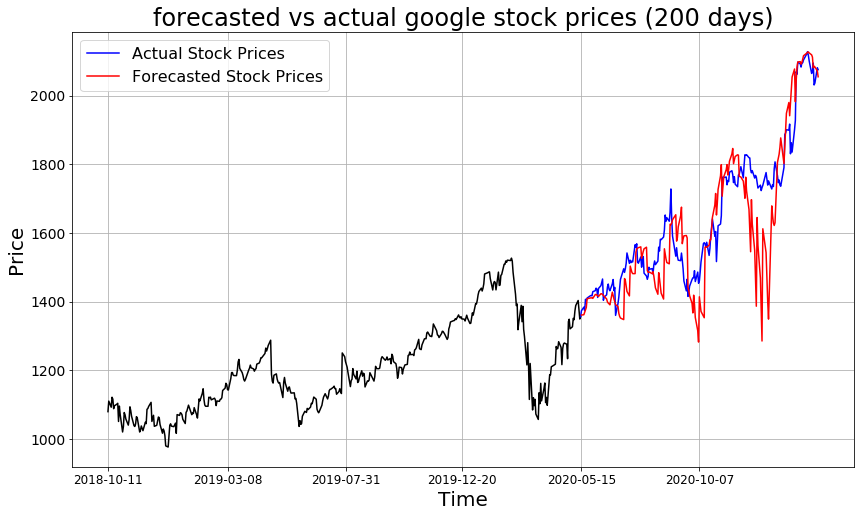

In [37]:
# Plot predictions from the LSTM model (prediction of five future days each time)
plt.figure(figsize=(14, 8))
plt.plot(df2[-600:-200], 'k-')
plt.plot(df2[-201:], 'b-', label='Actual Stock Prices')
plt.plot(df2[-200:].index, predicted_stock_price, 'r-', label='Forecasted Stock Prices')
plt.xticks(df2[-600:-1:100].index, fontsize=12)
plt.yticks(fontsize=14)
plt.title('forecasted vs actual google stock prices (200 days)', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(fontsize=16)
plt.grid();

### Conclusion:

1. Two deep learning algorithms were tested in time-series forecasting. The results show that LSTM is a better deep learning algorithm in forecasting time-series stock prices when compared to the standard RNN algorithm. As LSTM is able to determine what information will be stored and what discarded, its performance in time-series forecasting outperforms the standard RNN when the long-term memory is required for forecasting.
2. When compared to the standard RNN using 17801 parameters in the project, LSTM used a lot more of parameters (71051) even through it has the same neural network architecture as RNN. Thus, LSTM used a lot more of time to train these parameters. These are disadvantages for LSTM in time-series forecasting.
